# Load required libraries

In [1]:
import pandas as pd
import numpy as np
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Download the datasets from private S3 bucket

In [82]:
!aws s3 cp 's3://ads508-team4-master/df_psych.csv' ./data/

download: s3://ads508-team4-master/df_psych.csv to data/df_psych.csv


In [3]:
import csv

df_psych = pd.read_csv(
    "./data/df_psych.csv",
    delimiter=",",
    quoting=csv.QUOTE_NONE,
)
df_psych = df_psych.iloc[:,1:]
df_psych.head(100)

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,platform_y,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,season_id,series_id,studio_id,minutes_under_2
0,7.730941e+10,android,Psychographics,Movies Lovers,Religion and Faith Movies Fans,0.07,PH,android,8330,1,Movies,Horror,81,Indonesian,NaN,NaN,371.0,True
1,7.730941e+10,android,Psychographics,Movies Lovers,English Movies Fans,0.97,PH,android,8330,1,Movies,Horror,81,Indonesian,NaN,NaN,371.0,True
2,7.730941e+10,android,Psychographics,Movies Lovers,Music Movies Fans,0.54,PH,android,8330,1,Movies,Horror,81,Indonesian,NaN,NaN,371.0,True
3,7.730941e+10,android,Psychographics,Music Lovers,NaN,0.39,PH,android,8330,1,Movies,Horror,81,Indonesian,NaN,NaN,371.0,True
4,7.730941e+10,android,Psychographics,TV Lovers,English TV Fans,0.78,PH,android,8330,1,Movies,Horror,81,Indonesian,NaN,NaN,371.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.589935e+09,android,Psychographics,TV Lovers,Malay TV Fans,0.14,ID,android,8330,32,Movies,Horror,81,Indonesian,NaN,NaN,371.0,False
96,8.589935e+09,android,Psychographics,Mobile Enthusiasts,High Data Users,0.82,ID,android,8330,32,Movies,Horror,81,Indonesian,NaN,NaN,371.0,False
97,8.589935e+09,android,Psychographics,TV Lovers,Action and Adventure TV Fans,0.25,ID,android,8330,32,Movies,Horror,81,Indonesian,NaN,NaN,371.0,False
98,4.294967e+10,android,Psychographics,Movies Lovers,Tagalog Movies Fans,0.05,ID,android,8330,23,Movies,Horror,81,Indonesian,NaN,NaN,371.0,False


# Clean up missing values and outliers

## Missing values first

Recall that we have some missing values in the dataset

In [4]:
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4850
confidence_score         0
country_code             0
platform_y               0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    5
running_minutes          0
source_language        701
season_id           146311
series_id           146311
studio_id              300
minutes_under_2          0
dtype: int64

It occurs to us that some records don't have genres so we remove those specific records.

In [5]:
df_psych = df_psych.dropna(subset=['genre'])
df_psych.isnull().sum()
print('\n')

We are going to see which studios are missing the source language.

In [6]:
df1 = df_psych[['studio_id','source_language']]
df2 = df1.loc[df1['source_language'].isna()]
print(df2['studio_id'].unique())

[ 10. 229. 301.  79. 442. 127. 390.  69. 321. 373.  73. 170. 447. 226.
 111. 241.]


In [7]:
df1[df1['studio_id'].isin([229., 321.,  10., 301.,  79., 442., 373.,  73., 127., 390.,  69.,
       226., 170., 111., 241., 447.])].groupby('studio_id')['source_language'].nunique()

studio_id
10.0     2
69.0     1
73.0     0
79.0     0
111.0    0
127.0    1
170.0    1
226.0    2
229.0    1
241.0    0
301.0    0
321.0    0
373.0    0
390.0    1
442.0    0
447.0    1
Name: source_language, dtype: int64

For the studios that are missing source language, there can be no language, one language or two languages. To avoid confusion, we will remove records with missing studio_id and source_language.

In [8]:
df_psych = df_psych.dropna(subset=['studio_id','source_language'])
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4839
confidence_score         0
country_code             0
platform_y               0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    0
running_minutes          0
source_language          0
season_id           145653
series_id           145653
studio_id                0
minutes_under_2          0
dtype: int64

We can see that season_id and series_id have euqal amount of records and recall the showtype in the dataset has only 2 types.

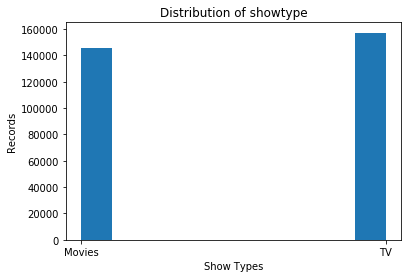

In [9]:
import matplotlib.pyplot as plt

plt.hist(df_psych['showtype'])
plt.xlabel("Show Types")
plt.ylabel("Records")
plt.title("Distribution of showtype")
plt.show()

In [10]:
df1 = df_psych[['showtype','season_id',"series_id"]]
df2 = df1.loc[(df1['season_id'].isna()) & (df1['series_id'].isna())]

In [11]:
df2.groupby('showtype')['season_id'].nunique()

showtype
Movies    1
Name: season_id, dtype: int64

In [12]:
df2.groupby('showtype')['series_id'].nunique()

showtype
Movies    1
Name: series_id, dtype: int64

This means that as long as we have valid season_id and series_id, the showtype must be TV shows while those values would be nulls for Movies.
Therefore, there is no need to keep season_id and series_id since they are directly correlated to showtype. So we remove the two columns.

In [13]:
df_psych = df_psych.drop(['season_id', 'series_id'], axis=1)
df_psych.isnull().sum()

user_id                0
platform_x             0
level_1                0
level_2                0
level_3             4839
confidence_score       0
country_code           0
platform_y             0
asset_id               0
minutes_viewed         0
showtype               0
genre                  0
running_minutes        0
source_language        0
studio_id              0
minutes_under_2        0
dtype: int64

In [14]:
pd.unique(df_psych['level_3'])

array(['Religion and Faith Movies Fans', 'English Movies Fans',
       'Music Movies Fans', nan, 'English TV Fans', 'Chinese Movies Fans',
       'Downloaders', 'Romance Movies Fans',
       'Documentary and Biography Movies Fans', 'Malay Movies Fans',
       'Thriller Movies Fans', 'player', 'Horror Movies Fans',
       'Tagalog Movies Fans', 'Documentary and Biography TV Fans',
       'Action and Adventure Movies Fans', 'Kids Movies Fans',
       'Local Commuters', 'Indonesian Movies Fans', 'Drama Movies Fans',
       'Sci-Fi Movies Fans', 'Animation Movies Fans', 'High Data Users',
       'Comedy Movies Fans', 'Drama TV Fans', 'Comedy TV Fans',
       'Family Movies Fans', 'Indonesian TV Fans', 'Korean TV Fans',
       'casual', 'Korean Movies Fans',
       '"""""""\\""""""""\\"""""""""""""""', 'addict',
       'Hindi Movies Fans', 'Fantasy Movies Fans', 'Kids TV Fans',
       'Vietnamese Movies Fans', 'Thai Movies Fans', 'Malay TV Fans',
       'Action and Adventure TV Fans', 'Real

Some level_3 traits are not valid, we will find out which level_2 traits those invalid level_3 traits belong to,
and replace the invalid level_3 traits to the same as level_2

In [15]:
lev3_null = df_psych.loc[df_psych['level_3'].isnull(), ('level_2')]
pd.unique(lev3_null)

array(['Music Lovers', 'Sports Fans', 'News Junkies & Avid Readers'],
      dtype=object)

In [16]:
# Replace level_3 traits for records having 
# level_2 traits as 'News Junkies & Avid Readers', 'Sports Fans', 'Music Lovers' with their own level_2 traits

df_psych['level_3'][df_psych.level_2 == 'News Junkies & Avid Readers'] = 'News Junkies & Avid Readers'
df_psych['level_3'][df_psych.level_2 == 'Sports Fans'] = 'Sports Fans'
df_psych['level_3'][df_psych.level_2 == 'Music Lovers'] = 'Music Lovers'

# hot-code level_3 trait for social media fans to social media fans
df_psych['level_3'][df_psych.level_2 == 'Social Media Fans'] = 'Social Media Fans'


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: Se

In [17]:
pd.unique(df_psych['level_3'])

array(['Religion and Faith Movies Fans', 'English Movies Fans',
       'Music Movies Fans', 'Music Lovers', 'English TV Fans',
       'Chinese Movies Fans', 'Downloaders', 'Romance Movies Fans',
       'Documentary and Biography Movies Fans', 'Malay Movies Fans',
       'Thriller Movies Fans', 'player', 'Horror Movies Fans',
       'Tagalog Movies Fans', 'Documentary and Biography TV Fans',
       'Action and Adventure Movies Fans', 'Kids Movies Fans',
       'Local Commuters', 'Indonesian Movies Fans', 'Drama Movies Fans',
       'Sci-Fi Movies Fans', 'Animation Movies Fans', 'High Data Users',
       'Comedy Movies Fans', 'Drama TV Fans', 'Comedy TV Fans',
       'Family Movies Fans', 'Indonesian TV Fans', 'Korean TV Fans',
       'casual', 'Korean Movies Fans', 'Social Media Fans', 'addict',
       'Hindi Movies Fans', 'Fantasy Movies Fans', 'Kids TV Fans',
       'Vietnamese Movies Fans', 'Thai Movies Fans', 'Malay TV Fans',
       'Action and Adventure TV Fans', 'Reality TV Fans',

## Now consider outliers..

Recall that we have plenty outilers in running_minutes and minutes_viewed

In [18]:
# Use a z-score of 3 as the cutoff

from scipy import stats


df_psych = df_psych[(np.abs(stats.zscore(df_psych['minutes_viewed']))< 3)]
df_psych = df_psych[(np.abs(stats.zscore(df_psych['running_minutes']))< 3)]

Text(0, 0.5, 'minutes_viewed')

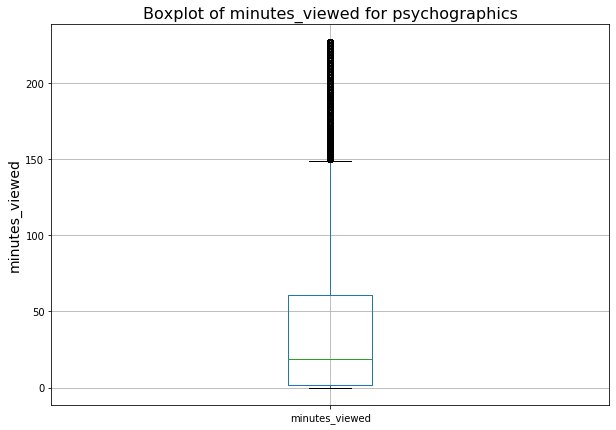

In [19]:
# Use boxplot to check for outliers in minutes_viewed

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['minutes_viewed'])
plt.title("Boxplot of minutes_viewed for psychographics", fontsize = 16)
plt.ylabel("minutes_viewed", fontsize= 14 )

Text(0, 0.5, 'running_minutes')

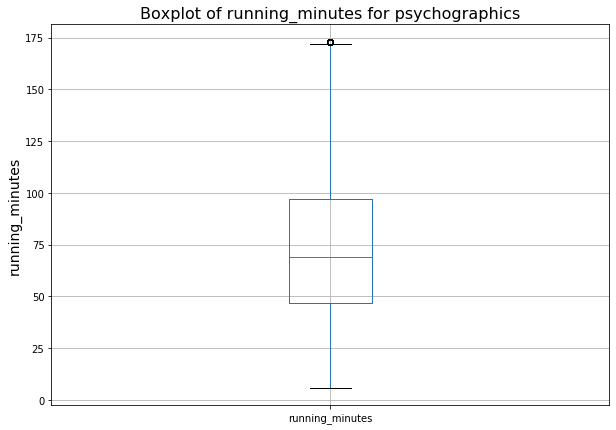

In [20]:
# Use boxplot to check for outliers in running_minutes

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['running_minutes'])
plt.title("Boxplot of running_minutes for psychographics", fontsize = 16)
plt.ylabel("running_minutes", fontsize= 14 )

# Feature Engineering

## Remove 'iflix Viewing Behaviour' from level_2 traits

In [21]:
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1
iflix Viewing Behaviour,1


Since "iflix Viewing Behaviour" doesn't fit into the rest of the traits, we will remove the records with it.

In [22]:
df_psych = df_psych[df_psych.level_2 != 'iflix Viewing Behaviour']
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1


## Simplify Certain Features

In [23]:
pd.unique(df_psych['source_language'])

array(['Indonesian', 'English', 'Tagalog', 'Chinese', 'Malay', 'Korean',
       'Hindi', 'Burmese', 'Japanese', 'Nepali', 'Kanuri', 'Thai',
       'Spanish; Castilian', 'Portuguese', 'Tamil', 'Vietnamese',
       'Central Khmer', 'Bengali', 'French', 'Urdu', 'Swahili', 'Italian',
       'Arabic', 'Hungarian', 'Turkish', 'Norwegian', 'Danish', 'Tajik',
       'Swedish', 'Sinhala; Sinhalese', 'Afrikaans', 'Avaric'],
      dtype=object)

In [24]:
pd.unique(df_psych['genre'])

array(['Horror', 'Sci-Fi', 'Action and Adventure', 'Kids', 'Animation',
       'Romance', 'Documentary and Biography', 'Comedy', 'Thriller',
       'Religion and Faith', 'Drama', 'Family', 'Others', 'Fantasy',
       'Crime and Mystery', 'Adult Romance', 'Anime', 'Reality',
       'Health and Fitness', 'Sports', 'Music', 'Lifestyle and Fashion',
       'Education', 'Game Show', 'eSports', 'Extreme Sports',
       'Best of Web or Viral', 'News', 'Live Events and Specials'],
      dtype=object)

In [25]:
pd.unique(df_psych['platform_x'])

array(['android', 'iOS', 'web', 'android-tv', 'webOS', 'web-pwa',
       'Samsung Tizen', 'Samsung Orsay', 'Roku', 'web-embed', 'Vewd',
       'googlecast', 'Panasonic'], dtype=object)

Simply the platform column

In [26]:
# Combine platforms into a more generalized group

def platform_type (row):
    if row['platform_x'] in ('android','iOS'):
        return 'mobile_phone'
    if row['platform_x'] in ('web-embed', 'webOS', 'web', 'web-pwa'):
        return 'web_based'
    if row['platform_x'] in ('android-tv', 'Panasonic', 'Roku', 'Samsung Tizen', 'googlecast', 'Vewd', 'Samsung Orsay'):
        return 'home_tv'
    return row['platform_x']

In [27]:
df_psych['platform_type'] = df_psych.apply(lambda row: platform_type(row), axis=1)

## Remove features that don't contribute to training models

In [28]:
df_psych = df_psych.drop(['user_id','level_1','level_3','asset_id','studio_id','minutes_under_2','platform_x','platform_y'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,running_minutes,source_language,platform_type
0,Movies Lovers,0.07,PH,1,Movies,Horror,81,Indonesian,mobile_phone
1,Movies Lovers,0.97,PH,1,Movies,Horror,81,Indonesian,mobile_phone
2,Movies Lovers,0.54,PH,1,Movies,Horror,81,Indonesian,mobile_phone
3,Music Lovers,0.39,PH,1,Movies,Horror,81,Indonesian,mobile_phone
4,TV Lovers,0.78,PH,1,Movies,Horror,81,Indonesian,mobile_phone


## Check Correlations between all independent variables

In [29]:
df = df_psych.drop(['level_2','confidence_score'],axis = 1)

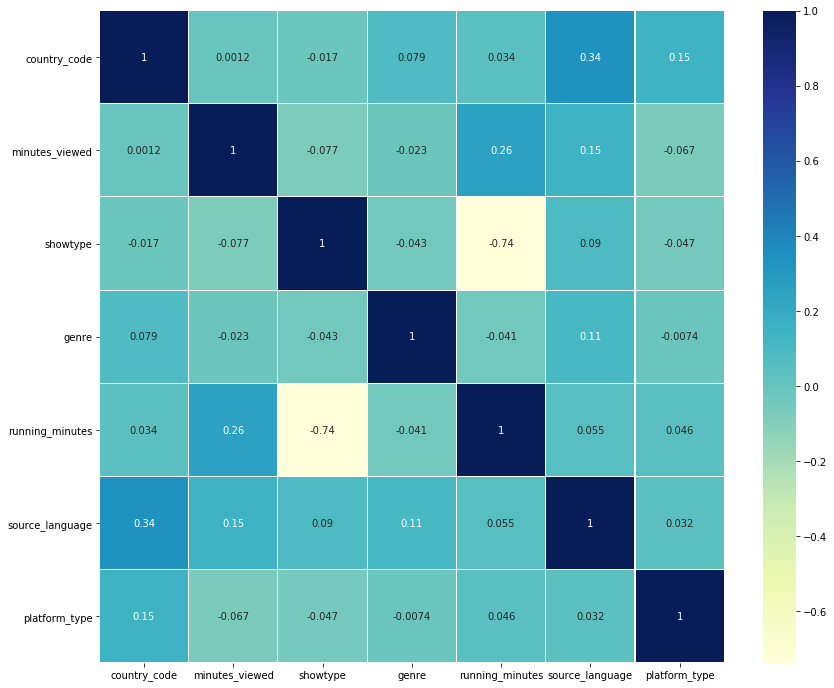

In [30]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
    
    
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

Removing running_minutes from the dataframe due to high correlation with showtype, which we can recall from this:

In [31]:
!pip install -U seaborn
sns.histplot(data=df_psych,x='running_minutes', hue = 'showtype', bins = 30)

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


AttributeError: module 'seaborn' has no attribute 'histplot'

running_minutes is almost directly related to the showtype.

In [32]:
df_psych = df_psych.drop(['running_minutes'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,source_language,platform_type
0,Movies Lovers,0.07,PH,1,Movies,Horror,Indonesian,mobile_phone
1,Movies Lovers,0.97,PH,1,Movies,Horror,Indonesian,mobile_phone
2,Movies Lovers,0.54,PH,1,Movies,Horror,Indonesian,mobile_phone
3,Music Lovers,0.39,PH,1,Movies,Horror,Indonesian,mobile_phone
4,TV Lovers,0.78,PH,1,Movies,Horror,Indonesian,mobile_phone


Before balancing the data, we need to look at the confidence score from the original dataset:

In [33]:
df_psych['confidence_score'].describe()

count    279458.000000
mean          0.597657
std           0.311564
min           0.000000
25%           0.300000
50%           0.650000
75%           0.890000
max           1.000000
Name: confidence_score, dtype: float64

In [34]:
print('50th percentile: ', df_psych['confidence_score'].quantile(.5))
print('60th percentile: ', df_psych['confidence_score'].quantile(.6))
print('70th percentile: ', df_psych['confidence_score'].quantile(.7))
print('80th percentile: ', df_psych['confidence_score'].quantile(.8))
print('90th percentile: ', df_psych['confidence_score'].quantile(.9))
print('95th percentile: ', df_psych['confidence_score'].quantile(.95))

50th percentile:  0.65
60th percentile:  0.76
70th percentile:  0.86
80th percentile:  0.92
90th percentile:  0.98
95th percentile:  1.0


We want to ensure data quality and pick our record within 70th percentile

In [35]:
df_psych = df_psych.loc[df_psych['confidence_score'] > .86]
df_psych['confidence_score'].describe()

count    80385.000000
mean         0.949884
std          0.043058
min          0.870000
25%          0.910000
50%          0.960000
75%          0.990000
max          1.000000
Name: confidence_score, dtype: float64

Remove confidence_score from the dataset

In [36]:
df_psych = df_psych.drop(['confidence_score'], axis = 1)

## Encoding for numeric values

In order to fit for XGBoost models, we need to encode numerica values into our dataset

In [37]:
df_psych.dtypes

level_2            object
country_code       object
minutes_viewed      int64
showtype           object
genre              object
source_language    object
platform_type      object
dtype: object

In [38]:
# Encoding showtype

df_psych = pd.get_dummies(df_psych,prefix=['showtype'], columns = ['showtype'], drop_first=True)

df_psych.head()

# Encoding genre
df_psych = pd.get_dummies(df_psych,prefix=['genre'], columns = ['genre'], drop_first=True)
df_psych.head()

# Encoding country_code
df_psych = pd.get_dummies(df_psych,prefix=['country_code'], columns = ['country_code'], drop_first=True)
df_psych.head()

# Encoding source language
df_psych = pd.get_dummies(df_psych,prefix=['source_language'], columns = ['source_language'], drop_first=True)
df_psych.head()

# Encoding platform_type
df_psych = pd.get_dummies(df_psych,prefix=['platform_type'], columns = ['platform_type'], drop_first=True)
df_psych.head()

# Encoding for the target variable level_2
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_psych['level_2'] = label_encoder.fit_transform(df_psych['level_2'])
df_psych.head()

,level_2,minutes_viewed,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,genre_Crime and Mystery,genre_Documentary and Biography,genre_Drama,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14,6,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


level_2 values:<br>

'Mobile Enthusiasts' = 1<br>
'Movies Lovers' = 2<br>
'Music Lovers' = 3<br>
'News Junkies & Avid Readers' = 4<br>
'Social Media Fans'= 5<br>
'Sports Fans'= 6<br>
'Travellers' = 7<br>
'TV Lovers' =8<br>

# Balance The Data

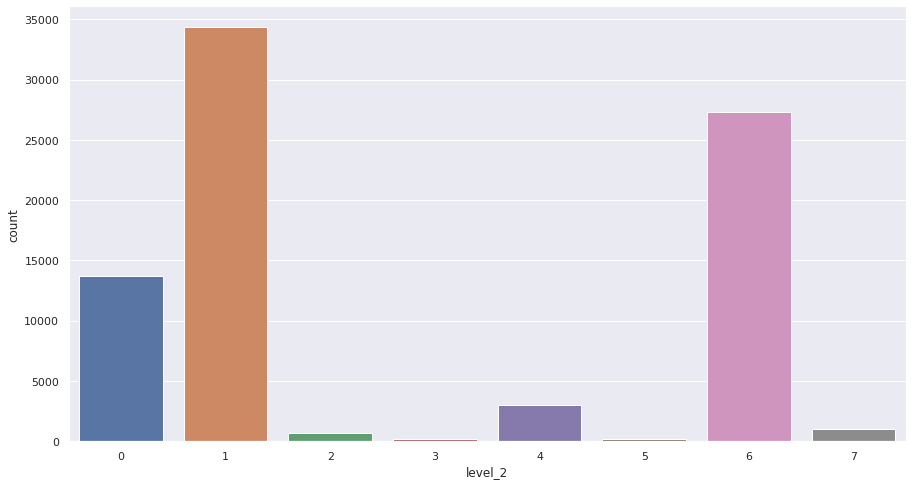

In [39]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_psych, x='level_2')

We can see that the target variable (level_3 trait_ has a strong right skewness and we want to balance the dataset

In [40]:
pd.set_option("display.max_rows", None)
df_psych['level_2'].value_counts()

1    34345
6    27306
0    13712
4     3000
7      992
2      714
5      163
3      153
Name: level_2, dtype: int64

In [41]:
df_grouped_by = df_psych.groupby(["level_2"])
df_balanced = df_grouped_by.apply(
lambda x: x.sample(df_grouped_by.size().max(),replace=True)\
.reset_index(drop=True)
)

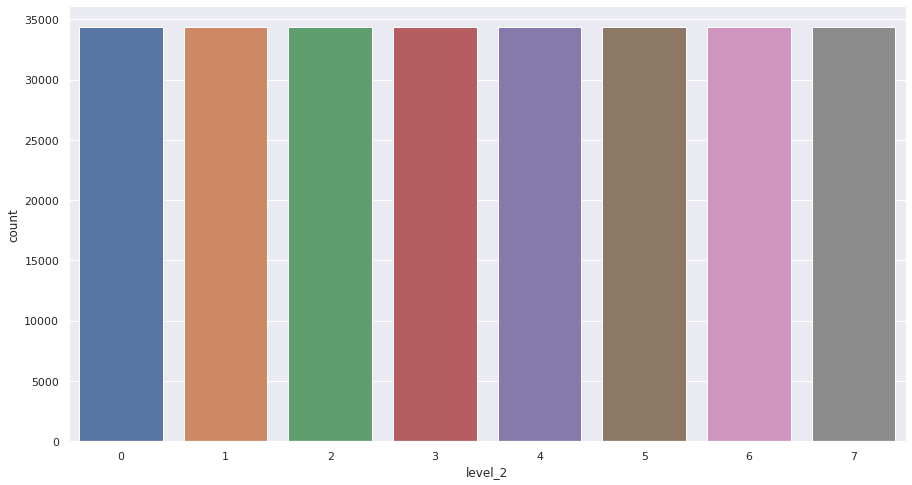

In [42]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_balanced, x='level_2')

In [43]:
df_balanced['level_2'].value_counts()

7    34345
6    34345
5    34345
4    34345
3    34345
2    34345
1    34345
0    34345
Name: level_2, dtype: int64

In [44]:
# Removs headers

df_psych = pd.DataFrame(df_psych)
df_psych.to_csv('df_psych.csv', header=False, index=False)
df_psych.head()

,level_2,minutes_viewed,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,genre_Crime and Mystery,genre_Documentary and Biography,genre_Drama,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14,6,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Split the data into train, validate and test

In [45]:
# Split the data as: train - 70%, validate - 15%, test - 15%

from sklearn.model_selection import train_test_split

# Split all data into 70% train and 30% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.30, stratify=df_balanced['level_2'])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout['level_2'])

In [46]:
df_train.shape

(192332, 77)

In [47]:
df_validation.shape

(41214, 77)

In [48]:
df_test.shape

(41214, 77)

# Save these files to S3 bucket

In [49]:
# Create a new s3 bucket
!aws s3 mb s3://ads508-team4-split

make_bucket: ads508-team4-split


In [84]:
# Store these 3 files

from io import StringIO

bucket = 'ads508-team4-split'

csv_buffer1 = StringIO()
csv_buffer2 = StringIO()
csv_buffer3 = StringIO()

df_train.to_csv(csv_buffer1)
df_validation.to_csv(csv_buffer2)
df_test.to_csv(csv_buffer3)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'df_train.csv').put(Body=csv_buffer1.getvalue())
s3_resource.Object(bucket, 'df_validation.csv').put(Body=csv_buffer2.getvalue())
s3_resource.Object(bucket, 'df_test.csv').put(Body=csv_buffer3.getvalue())

{'ResponseMetadata': {'RequestId': 'AP8T1NEE08H716X7',
  'HostId': 'OfrR/9kun1nB0K2kZWd3K7W3qH7mqZ3BsPRJPudgsADxTrgaZAbvBPdN80Q/HkQPOv5Oo8uLEoc=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'OfrR/9kun1nB0K2kZWd3K7W3qH7mqZ3BsPRJPudgsADxTrgaZAbvBPdN80Q/HkQPOv5Oo8uLEoc=',
   'x-amz-request-id': 'AP8T1NEE08H716X7',
   'date': 'Sat, 02 Apr 2022 23:00:48 GMT',
   'x-amz-version-id': '8DL.GaetWsnXuWQgCbwLXeAP2yijzOg3',
   'etag': '"8f6f80b110aa3573a73f2c9229d318ff"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"8f6f80b110aa3573a73f2c9229d318ff"',
 'VersionId': '8DL.GaetWsnXuWQgCbwLXeAP2yijzOg3'}

In [77]:
cols_input = list(df_train.columns)

In [78]:
cols_input.remove('level_2')


In [81]:
cols_input

['minutes_viewed',
 'showtype_TV',
 'genre_Adult Romance',
 'genre_Animation',
 'genre_Anime',
 'genre_Comedy',
 'genre_Crime and Mystery',
 'genre_Documentary and Biography',
 'genre_Drama',
 'genre_Education',
 'genre_Extreme Sports',
 'genre_Family',
 'genre_Fantasy',
 'genre_Game Show',
 'genre_Health and Fitness',
 'genre_Horror',
 'genre_Kids',
 'genre_Lifestyle and Fashion',
 'genre_Live Events and Specials',
 'genre_Music',
 'genre_News',
 'genre_Others',
 'genre_Reality',
 'genre_Religion and Faith',
 'genre_Romance',
 'genre_Sci-Fi',
 'genre_Sports',
 'genre_Thriller',
 'genre_eSports',
 'country_code_BN',
 'country_code_EG',
 'country_code_GH',
 'country_code_ID',
 'country_code_IQ',
 'country_code_KE',
 'country_code_KH',
 'country_code_LB',
 'country_code_LK',
 'country_code_MM',
 'country_code_MY',
 'country_code_NP',
 'country_code_PH',
 'country_code_PK',
 'country_code_SD',
 'country_code_TH',
 'country_code_VN',
 'country_code_ZW',
 'source_language_Bengali',
 'source

In [83]:
df_train.columns

Index(['level_2', 'minutes_viewed', 'showtype_TV', 'genre_Adult Romance',
       'genre_Animation', 'genre_Anime', 'genre_Comedy',
       'genre_Crime and Mystery', 'genre_Documentary and Biography',
       'genre_Drama', 'genre_Education', 'genre_Extreme Sports',
       'genre_Family', 'genre_Fantasy', 'genre_Game Show',
       'genre_Health and Fitness', 'genre_Horror', 'genre_Kids',
       'genre_Lifestyle and Fashion', 'genre_Live Events and Specials',
       'genre_Music', 'genre_News', 'genre_Others', 'genre_Reality',
       'genre_Religion and Faith', 'genre_Romance', 'genre_Sci-Fi',
       'genre_Sports', 'genre_Thriller', 'genre_eSports', 'country_code_BN',
       'country_code_EG', 'country_code_GH', 'country_code_ID',
       'country_code_IQ', 'country_code_KE', 'country_code_KH',
       'country_code_LB', 'country_code_LK', 'country_code_MM',
       'country_code_MY', 'country_code_NP', 'country_code_PH',
       'country_code_PK', 'country_code_SD', 'country_code_TH',
     